In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import optimize as opt

In [2]:
#opt.minimize? #you can use this "question mark" syntax to display information about any built-in or user-defined function

In [3]:
def _validate_inputs(tc,  pfd, pO2m, pco2):
    def make_array(val):
        if np.isscalar(val):
            val = np.array([val])
        else:
            val = np.array(val)
            
        return val

    tc = make_array(tc)
    pfd = make_array(pfd)
    pO2m = make_array(pO2m)
    pco2 = make_array(pco2)
    
    inputs_dict = [tc, pfd, pO2m, pco2]
    
    array_lens = np.array([tc.size, pfd.size, pO2m.size, pco2.size])
    
    Nmax = np.max(array_lens)

    assert np.all((array_lens==Nmax)|(array_lens==1)), 'Environmental vars are not consistent'
    
    def tile_input(val, Nmax=Nmax):
        if len(val)<Nmax:
            val = np.tile(val,Nmax)
            
        return val
    
    tc = tile_input(tc)
    pfd = tile_input(pfd)
    pO2m = tile_input(pO2m)
    pco2 = tile_input(pco2)
    
    return tc,  pfd, pO2m, pco2


def fn_photosyn(tc,  pfd, pO2m, pco2, vegProp):
    """
    Photosynthesis modeling function.
    
    original code from Joe Berry
    adapted by Inez Fung
    updated by Gretchen Keppel-Aleks
    Collatz et al.: Physiological and environmental regulation of stomatal
        conductance, photosynthesis:  a model that includes a laminar
        boundary layer.  Agric and Forest Meteorology,54, 107-136 (1991).

    Parameters
    ----------
    tc : float (scalar or array)
        Temperature in Celsius
    pfd : float (scalar or array)
        Photon flux density in mol m-2 s-1
    pO2m : float (scalar or array)
        Pressure of O2 in pascals
    pco2 : float (scalar or array)
        Pressure of CO2 in pascals
    vegProp : dict
        Dictionary of properties for vegetation type. Defines fields:
            
        c4 : {0, 1}
            Flag for whether plant type is c4 (1) or not c4 (0)
        vmax : float
            blah
        effcon : float
            blah
        hhti : float
            blah
        hlti : float
            blah


    Returns
    -------
    

    Notes
    -----
        
    The equations are in the Appendix
    -----------------------------------------------------------------------
    Select C3 or C4 biochemistry and calculate limiting cases
        omc            rubisco limited assimilation (mol m-2 s-1)
                        (omega-c): equation (11) , SE-92A
        ome            light limited assimilation (mol m-2 s-1)
                        (omega-e): equation (12) , SE-92A
        oms            sink limited assimilation (mol m-2 s-1)

    Following Farquar et al. 1980
        assimilation (assim) is the minimal of {omc, ome, oms}
        NetAssimilation (assimn) = assim - daytime leaf respiration

    -----------------------------------------------------------------------
    the model works in the following units

        pco2c, po2m                              : pascals
        vmax, pfd                                : mol m-2 s-1
        effcon                                   : mol co2 mol quanta-1
        tc                                       : oC
        rstfac                                   : stress factor 0<restfac<1
        c3, c4                                   : logical

    --------------------------------------------------------------
    """
    
    #vegprop
    c4=vegProp['c4']
    vmax=vegProp['vmax']
    effcon=vegProp['effcon']
    hhti=vegProp['hhti']
    hlti=vegProp['hlti']
    

    tc,  pfd, pO2m, pco2 = _validate_inputs(tc,  pfd, pO2m, pco2)
    N = len(tc)

    #convert input units to model units
    pco2c=pco2*0.1 # ppm to Pa
    vmax=1e-6*vmax #mole/m2/s to umol/m2/s
    pO2m=pO2m*1e3 # % to Pa
    par=pfd*4.6e-6 # absorbed photon flux
    
    #assume common to all veg
    rstfac=1
    slti=0.2
    shti=0.3

    #  Calculate temperature effects according to Q10 function,
    #  Collatz 91 Table 1 lists values of constants
    #      25C is the reference temperature for all kinetic constant
    #      2.1 is Q10 for CO2 Rubisco
    #      1.2 is the Q10 for O2 inhibition

    tk = tc+273.16
    tref = 298
    qt = (tk - tref)/10.
    vm = vmax * 2.1 **qt
    zkc = 25. * 2.1 **qt;         # carboxylation                                       
    zko = 30000. * 1.2 **qt;      # O2 inhibition                                       
    spfy = 2600. * 0.57 **qt;

    #-------------------------------------------------------------
    # Stress limits on Vmax and Respiration
    #-------------------------------------------------------------
    templ = 1. + np.exp(slti * (hlti-tk))
    temph = 1. + np.exp(shti * (tk-hhti))
    rstfac3 = 1. / ( templ * temph)

    #----------------------------------------------------------------------
    #   solve for ome, oms, omc
    #-------------------------------------------------------------------------
    btheta = 0.95
    if c4 == 1:
          atheta = 0.8 #curvature parameter in first quadratic (see Collatz'92 and Sellers'96)
          respc = 0.025 * vmax * 1.8 **qt #scale respiration to vm
          respc = respc / (1 + np.exp(1.3 * (tk - 328))) #high temp limit on respc
          gammas = 0.01*np.ones(N) # compensation point (near, but not zero)
          rrkk = 1.8 ** qt * vmax / 5 #first order rate constant for PEPcase
          vm = vm * rstfac * rstfac3 
          omc = vm #maximum carboxylation capacity in the bundle sheath
          ome = par * effcon #light limited potential rate of CO2 fixation
          oms = rrkk * pco2c #CO2 limited rate
    else:
          atheta = 0.98 #curvature paramenter in first quadratic
          respc = 0.015 * vmax * 1.8 ** qt #scales respiration to vm
          respc = respc / (1 + np.exp(1.3 * (tk - 328))) #high temp limit on respc
          rrkk = zkc * (1 + pO2m /zko) # oxygen effect on zkc
          vm    = vm / temph * rstfac #adjust vm for high temperature and water stress
          gammas = 0.5 * pO2m / spfy # compensation point, Collatz'91 A3
          omc = vm * (pco2c - gammas) / (pco2c + rrkk) #Collatz'91 A5
          ome = par * effcon * (pco2c - gammas) / (pco2c + 2 *gammas) #Collatz'91 A2
          oms = vmax * rstfac * 1.8 **qt / 2 #Collatz'90 A7

    # print(atheta)
    # print(btheta)
    # print(gammas)
    
    def solve_quad_assim(ome, omc, oms, pco2c,gammas, 
                         atheta=atheta, btheta=btheta):
        #---------------------------------------------------------------------
        #
        #    Solve the first quadratic for omp  (Collatz 91, A8)
        #        theta*omp^2 - omp*(ome+omc) + ome*omc = 0
        #
        #-----------------------------------------------------------------------
        sqrtin = np.max( [0, ( (ome + omc) **2 - 4 * atheta * ome * omc )] )               

        #-------------------------------------------------------------------------
        #     switch roots at gammas
        #-------------------------------------------------------------------------
        omp1   = ( ( ome+omc ) -  sqrtin  **0.5 ) / ( 2 * atheta )
        omp2   = ( ( ome+omc ) +  sqrtin  **0.5 ) / ( 2 * atheta )
        a = (pco2c >= gammas)
        b = (pco2c <= gammas)
        omp=omp1 *a + omp2 *b;

        #--------------------------------------------------------------------------
        #
        #       Solve the second quadratic for assim
        #       The quadratic is an empirical fit to observations
        #         btheta*A^2 - A(omp+oms) + omp*oms = 0  (Collatz 91, A9)
        #
        #---------------------------------------------------------------------------            

        sqrtin = np.max( [0., ( (omp + oms) **2 - 4 * btheta * omp * oms )] );                
        assim = ( ( oms + omp ) - sqrtin **0.5 ) / ( 2 * btheta );
        
        return assim
    
    assim = []
    for iome, iomc, ioms, ipco2c, igammas in zip(ome, omc, oms, pco2c, gammas):  
        iassim = solve_quad_assim(iome, iomc, ioms, ipco2c, igammas)
        assim.append(iassim)

    assim = np.array(assim)

    #--------------------------------------------------------------------------
    #       Net assimiation is the assimilation minus daytime Canopy Respiration
    #---------------------------------------------------------------------------
    assimn =  (assim - respc);
    return (assimn, assim, respc, omc, ome, oms)


In [4]:
### Define Dictionaries for three different vegetation types
# C4 vegetation
C4dict={'c4':1,'vmax':30, 'effcon':0.05, 'hhti':313, 'hlti':288, 'plotcol':[0.7, 0.7, 0.2]}
# Broadleaf Evergreen vegetation
BLEdict={'c4':0,'vmax':100, 'effcon':0.08, 'hhti':313, 'hlti':288,'plotcol':[0.2, 0.7, 0.2]}
# Needleleaf Evergreen vegetation
NLEdict={'c4':0,'vmax':60, 'effcon':0.08, 'hhti':303, 'hlti':278,'plotcol':[0.2, 0.2, 0.7]}





In [5]:
### Set default parameters
tc_default=15 #deg C
pfd_default=400 #mol/m2/s - watts/m2 to mol/m2/s
pO2m_default=21 #percent - pascal to percent
pco2_default=300 #ppm - pascal to pCO2

(array([10]),) (array([110]),)
[0.83444337]
[834.44336537]
(array([10]),) (array([110]),)
[8.72905937e-09]
[0.87290594]


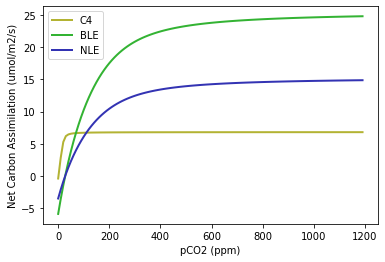

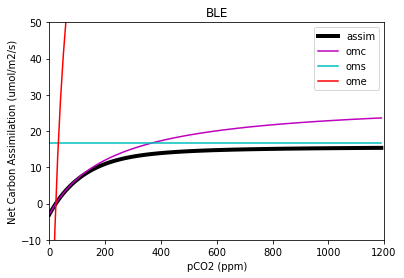

In [67]:
# Vary pco2

pco2=np.arange(0,1200,10)
#print(pco2)
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m_default, pco2, C4dict)

plt.figure()
hc4=plt.plot(pco2, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')
#plt.plot(pco2, 1e6*assim, '--', color=C4dict['plotcol'], linewidth=2, label='C4') # this line plots net assimilation
                                                                                  # you may choose to emulate for other types
                                                                                  # or you may choose to comment out
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m_default, pco2, BLEdict)
hble=plt.plot(pco2, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m_default, pco2, NLEdict)
hnle=plt.plot(pco2, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')
j300=np.where(pco2==100)
j500=np.where(pco2==1100)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/(0.5*(assimn[j500]+assimn[j300])) # fractional change is assimilation
print(deltaA) # finding the midpoint of a slope basically
print(10**6*deltaA/1000) # divide by change in CO2 so 1100-100 so units are per ppm CO2

j300=np.where(pco2==100)
j500=np.where(pco2==1100)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/1000
print(deltaA)
print((10**6*deltaA)*100)

plt.legend()
#plt.xlim([300,500])
plt.xlabel('pCO2 (ppm)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
#plt.title('Varied CO2')
### Add labels, Make sure to use correct units


# Analyze limiting factors -- note that the plot uses values for only the LAST vegetation type you ran,
# since you overwrite the C4 omc value when you call fn_photosyn for BLE, and 
# you overwrite that when you call fn_photosyn for NLE below that.  
# but this should be a useful template
plt.figure()
plt.plot(pco2, 1e6*assim, 'k', linewidth=4,label="assim")
plt.plot(pco2, 1e6*omc, 'm',label="omc")
plt.plot(pco2, 1e6*oms, 'c',label="oms")
plt.plot(pco2, 1e6*ome, 'r',label="ome")
plt.xlim([0,1200])
plt.ylim([-10, 50])
plt.xlabel('pCO2 (ppm)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.title('BLE')
plt.legend()



(array([1]),) (array([8]),)
[-1.19312247e-10]
[-5.96561235e-06]
(array([1]),) (array([9]),)
[-2.57128857e-07]
[-25.71288571]


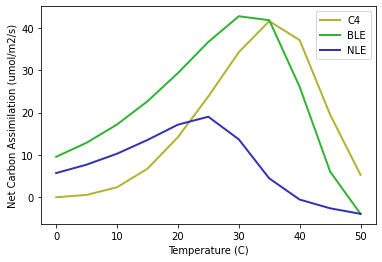

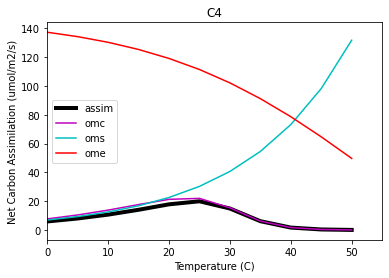

In [64]:
# Vary temperature

tc=np.arange(0,55,5)

[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc, pfd_default, pO2m_default, pco2_default, C4dict)
hc4=plt.plot(tc, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')
#hc4=plt.plot(tc, 1e6*assim, '--', color=C4dict['plotcol'], linewidth=2)
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc, pfd_default, pO2m_default, pco2_default, BLEdict)
hble=plt.plot(tc, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc, pfd_default, pO2m_default, pco2_default, NLEdict)
hnle=plt.plot(tc, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')
j300=np.where(tc==5)
j500=np.where(tc==40)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/0.5*(assimn[j500]+assimn[j300])
print(deltaA)
print(10**6*deltaA/20)

j300=np.where(tc==5)
j500=np.where(tc==45)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/40
print(deltaA)
print((10**6*deltaA)*100)
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')

plt.figure()
plt.plot(tc, 1e6*assim, 'k', linewidth=4,label="assim")
plt.plot(tc, 1e6*omc, 'm',label="omc")
plt.plot(tc, 1e6*oms, 'c',label="oms")
plt.plot(tc, 1e6*ome, 'r',label="ome")
plt.xlim([0,55])
#plt.ylim([-10, 100])
plt.xlabel('Temperature (C)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.title('C4')
plt.legend()

## Add labels, make sure you add units

(array([10]),) (array([110]),)
[6.84723927e-06]
[0.01141207]
(array([10]),) (array([110]),)
[5.18245239e-10]
[0.05182452]


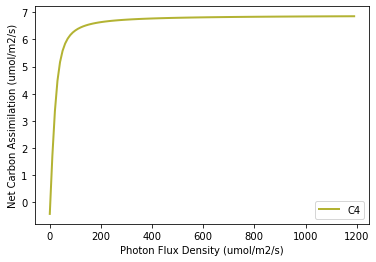

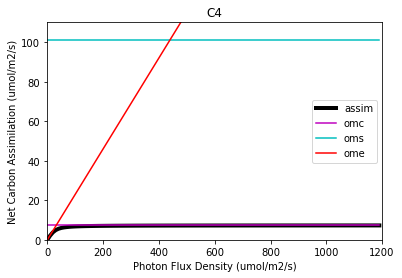

In [48]:
# Vary pfd
 
pfd=np.arange(0,1200,10)
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd, pO2m_default, pco2_default, C4dict)
hc4=plt.plot(pfd, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')
#hc4=plt.plot(tc, 1e6*assim, '--', color=C4dict['plotcol'], linewidth=2)
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd, pO2m_default, pco2_default, BLEdict)
#hble=plt.plot(pfd, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd, pO2m_default, pco2_default, NLEdict)
#hnle=plt.plot(pfd, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')
j300=np.where(pfd==100)
j500=np.where(pfd==1100)
print(j300,j500)
deltaA=assimn[j500]-assimn[j300]/0.5*(assimn[j500]+assimn[j300])
print(deltaA)
print(10**6*deltaA/600)

j300=np.where(pfd==100)
j500=np.where(pfd==1100)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/1000
print(deltaA)
print((10**6*deltaA)*100)

plt.legend()
plt.xlabel('Photon Flux Density (umol/m2/s)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')

plt.figure()
plt.plot(pfd, 1e6*assim, 'k', linewidth=4,label="assim")
plt.plot(pfd, 1e6*omc, 'm',label="omc")
plt.plot(pfd, 1e6*oms, 'c',label="oms")
plt.plot(pfd, 1e6*ome, 'r',label="ome")
plt.xlim([0,1200])
plt.ylim(0,110)
plt.xlabel('Photon Flux Density (umol/m2/s)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.title('C4')
plt.legend()

(array([1]),) (array([7]),)
[0.]
[0.]
(array([1]),) (array([7]),)
[0.]
[0.]


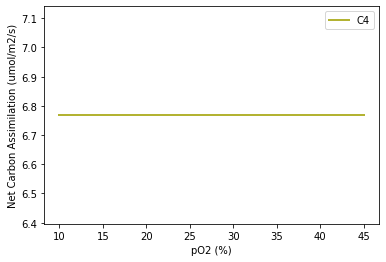

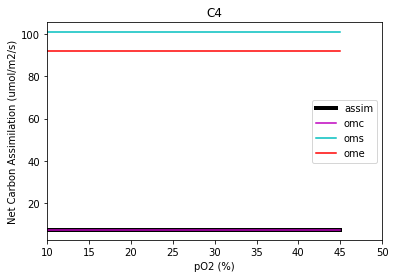

In [51]:
# Vary oxygen
pO2m=np.arange(10,50,5)
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m, pco2_default, C4dict)
hc4=plt.plot(pO2m, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')
#hc4=plt.plot(tc, 1e6*assim, '--', color=C4dict['plotcol'], linewidth=2)
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m, pco2_default, BLEdict)
#hble=plt.plot(pO2m, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m, pco2_default, NLEdict)
#hnle=plt.plot(pO2m, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')
j300=np.where(pO2m==15)
j500=np.where(pO2m==45)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/0.5*(assimn[j500]+assimn[j300])
print(deltaA)
print(10**6*deltaA/30)

j300=np.where(pO2m==15)
j500=np.where(pO2m==45)
print(j300,j500)
deltaA=(assimn[j500]-assimn[j300])/30
print(deltaA)
print((10**6*deltaA)*100)

plt.legend()
plt.xlabel('pO2 (%)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')

plt.figure()
plt.plot(pO2m, 1e6*assim, 'k', linewidth=4,label="assim")
plt.plot(pO2m, 1e6*omc, 'm',label="omc")
plt.plot(pO2m, 1e6*oms, 'c',label="oms")
plt.plot(pO2m, 1e6*ome, 'r',label="ome")
plt.xlim([10,50])
#plt.ylim([0, 105])
plt.xlabel('pO2 (%)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.title('C4')
plt.legend()

Text(0.5, 1.0, 'Increasing CO2')

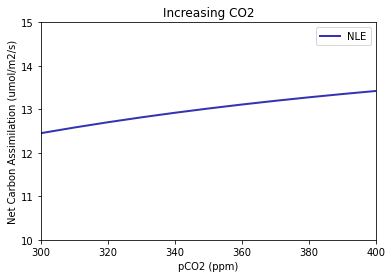

In [52]:
pco2=np.arange(0,1200,10)

plt.figure()

#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m_default, pco2, C4dict)
#hc4=plt.plot(pco2, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')

#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m_default, pco2, BLEdict)
#hble=plt.plot(pco2, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')

[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd_default, pO2m_default, pco2, NLEdict)
hnle=plt.plot(pco2, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')


plt.legend()
plt.xlabel('pCO2 (ppm)')
plt.xlim(300,400)
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.ylim(10,15)
plt.title('Increasing CO2')
### Add labels, Make sure to use correct units

Text(0.5, 1.0, 'Seasonal PFD')

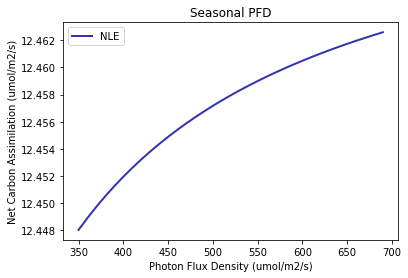

In [60]:
pfd=np.arange(350,700,10)
plt.figure()
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd, pO2m_default, pco2_default, C4dict)
#hc4=plt.plot(pfd, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')
#hc4=plt.plot(tc, 1e6*assim, '--', color=C4dict['plotcol'], linewidth=2)
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd, pO2m_default, pco2_default, BLEdict)
#hble=plt.plot(pfd, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc_default, pfd, pO2m_default, pco2_default, NLEdict)
hnle=plt.plot(pfd, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')
plt.legend()
plt.xlabel('Photon Flux Density (umol/m2/s)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.title('Seasonal PFD')

Text(0.5, 1.0, 'Daily Temperature')

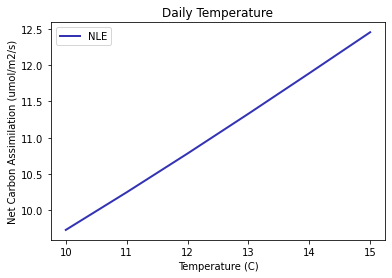

In [59]:
tc=np.arange(10,16,1)

#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc, pfd_default, pO2m_default, pco2_default, C4dict)
#hc4=plt.plot(tc, 1e6*assimn, color=C4dict['plotcol'], linewidth=2, label='C4')
#hc4=plt.plot(tc, 1e6*assim, '--', color=C4dict['plotcol'], linewidth=2)
#[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc, pfd_default, pO2m_default, pco2_default, BLEdict)
#hble=plt.plot(tc, 1e6*assimn, color=BLEdict['plotcol'], linewidth=2, label='BLE')
[assimn, assim, respc, omc, ome, oms]=fn_photosyn(tc, pfd_default, pO2m_default, pco2_default, NLEdict)
hnle=plt.plot(tc, 1e6*assimn, color=NLEdict['plotcol'], linewidth=2, label='NLE')

plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('Net Carbon Assimilation (umol/m2/s)')
plt.title('Daily Temperature')